<ipython-input-19-f9f5d4393109>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("/kaggle/input/modelsqa/MultiRegionCNN_SVideoQA.pth", map_location=devic

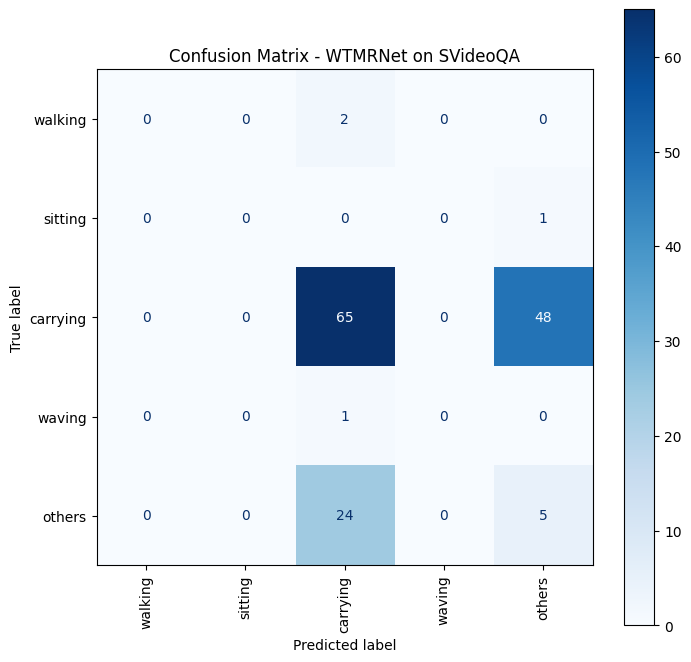

In [19]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

categories = [
    "carrying", "holding", "looking", "sitting", 
    "standing", "turning", "walking", "waving"
]

main_categories = [
    "walking", 
    "sitting", 
    "carrying", 
    "waving"
]

# Final reduced categories
reduced_categories = main_categories + ["others"]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
num_classes = len(categories)
model = WTMRNet(num_classes=num_classes).to(device)
state = torch.load("/kaggle/input/modelsqa/MultiRegionCNN_SVideoQA.pth", map_location=device)
model.load_state_dict(state["model_state_dict"])
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_label_names = [categories[i] for i in true_labels]
pred_label_names = [categories[i] for i in pred_labels]

category_map = {cat: (cat if cat in main_categories else "others") for cat in categories}
true_reduced_names = [category_map[name] for name in true_label_names]
pred_reduced_names = [category_map[name] for name in pred_label_names]

label_to_index = {label: i for i, label in enumerate(reduced_categories)}
true_encoded = [label_to_index[name] for name in true_reduced_names]
pred_encoded = [label_to_index[name] for name in pred_reduced_names]

cm = confusion_matrix(true_encoded, pred_encoded, labels=list(range(len(reduced_categories))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reduced_categories)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix - WTMRNet on SVideoQA")
plt.show()

In [3]:
!pip install --quiet ptflops thop

In [22]:
import torch
import time
from thop import profile
from tqdm import tqdm
import numpy as np
from einops import rearrange
from timm.models.vision_transformer import Block

# Define model classes
class MultiRegionCNN(nn.Module):
    def __init__(self):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, T, -1, x.size(2), x.size(3))
        x = nn.functional.interpolate(x.view(B*T, -1, x.size(-2), x.size(-1)), size=(16, 16), mode='bilinear')
        x = x.view(B, T, -1, 16, 16)
        return x 

class TimeSformer(nn.Module):
    def __init__(self, num_frames=16, img_size=56, patch_size=8, embed_dim=768, num_heads=12, depth=12, num_classes=8):
        super(TimeSformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2  
        self.patch_dim = patch_size * patch_size * 128  
        self.embed_dim = embed_dim
        self.num_frames = num_frames

        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = rearrange(x, 'b t c (h p1) (w p2) -> (b t) (h w) (p1 p2 c)', p1=8, p2=8)
        num_patches = (H // 8) * (W // 8)
        patch_dim = 8 * 8 * C
        x = x.view(B * T, num_patches, patch_dim)

        x = self.patch_embedding(x)
        x = x + self.position_embedding[:, :x.shape[1], :]
        x = rearrange(x, '(b t) n d -> b (t n) d', b=B)
        x = x + self.temporal_embedding[:, :x.shape[1], :]  
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x

class WTMRNet(nn.Module):
    def __init__(self, num_classes):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)
    
    def forward(self, x):
        x = self.multi_region_cnn(x)
        x = self.timesformer(x)
        return x

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8
model = WTMRNet(num_classes=num_classes).to(device)
checkpoint = torch.load("/kaggle/input/modelsqa/MultiRegionCNN_SVideoQA.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

# Example input
sample_input = torch.randn(1, 16, 3, 56, 56).to(device)

# 1. Model Parameters (Total)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
total_params_m = total_params / 1e6

# 2. GFLOPs (MACs)
macs, _ = profile(model, inputs=(sample_input,), verbose=False)
gflops = macs / 1e9

# 3. Average Inference Time per Clip
def measure_inference_time(model, input_tensor, runs=100):
    torch.cuda.empty_cache()
    timings = []
    with torch.no_grad():
        for _ in tqdm(range(runs), desc="Profiling Inference Time"):
            start = time.time()
            _ = model(input_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.time()
            timings.append(end - start)
    return np.mean(timings), np.std(timings)

avg_time, std_time = measure_inference_time(model, sample_input)
throughput = 1.0 / avg_time

# 5. Total Training Time
avg_epoch_time = 50  # seconds
num_epochs = 30
total_training_time_hrs = (avg_epoch_time * num_epochs) / 3600

# Print results in desired format
print(f"Model Parameters (Total): {total_params_m:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {gflops:.2f} GFLOPs")
print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")
print(f"Total Training Time: {total_training_time_hrs:.2f} hours")


<ipython-input-22-9710397d569b>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/modelsqa/MultiRegionCNN_SVideoQA.pth", map_location=

Model Parameters (Total): 92.61 M
GFLOPs (Multiply-Accumulate Ops): 6.94 GFLOPs
Average Inference Time per Clip: 0.0101 seconds
Throughput: 99.07 clips/second
Total Training Time: 0.42 hours


In [25]:
import torch
import time
from thop import profile
from tqdm import tqdm
import numpy as np
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128 * 56 * 56, num_classes)  

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, T, -1)
        x = torch.mean(x, dim=1)  
        x = self.fc(x)
        return x


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8
model = MultiRegionCNN(num_classes=num_classes).to(device)
checkpoint = torch.load("/kaggle/input/modelsqa/WTMRNet_SVideoQA.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

# Example input
sample_input = torch.randn(1, 16, 3, 224, 224).to(device)

# 1. Model Parameters (Total)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
total_params_m = total_params / 1e6

# 2. GFLOPs (MACs)
macs, _ = profile(model, inputs=(sample_input,), verbose=False)
gflops = macs / 1e9

# 3. Average Inference Time per Clip
def measure_inference_time(model, input_tensor, runs=100):
    torch.cuda.empty_cache()
    timings = []
    with torch.no_grad():
        for _ in tqdm(range(runs), desc="Profiling Inference Time"):
            start = time.time()
            _ = model(input_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.time()
            timings.append(end - start)
    return np.mean(timings), np.std(timings)

avg_time, std_time = measure_inference_time(model, sample_input)
throughput = 1.0 / avg_time

# 5. Total Training Time
avg_epoch_time = 32  # seconds
num_epochs = 30
total_training_time_hrs = (avg_epoch_time * num_epochs) / 3600

# Print results in desired format
print(f"Model Parameters (Total): {total_params_m:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {gflops:.2f} GFLOPs")
print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")
print(f"Total Training Time: {total_training_time_hrs:.2f} hours")


<ipython-input-25-f32a950f09d7>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/modelsqa/WTMRNet_SVideoQA.pth", map_location=device)

Model Parameters (Total): 3.29 M
GFLOPs (Multiply-Accumulate Ops): 16.19 GFLOPs
Average Inference Time per Clip: 0.0150 seconds
Throughput: 66.55 clips/second
Total Training Time: 0.27 hours


In [27]:
import torch
import time
from thop import profile
from tqdm import tqdm
import numpy as np
from einops import rearrange
from timm.models.vision_transformer import Block

import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer(nn.Module):
    def __init__(self, num_classes=8, num_frames=16, img_size=224, patch_size=16, embed_dim=768, num_heads=12, depth=12):
        super(TimeSformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2  
        self.patch_dim = patch_size * patch_size * 3  
        self.embed_dim = embed_dim
        self.num_frames = num_frames

        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_frames * self.num_patches, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.randn(1, self.num_frames * self.num_patches, embed_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()  

        x = rearrange(x, 'b t c (h p1) (w p2) -> (b t) (h w) (p1 p2 c)', p1=16, p2=16)

        P, _ = x.shape[-2:]  
        patch_dim = x.shape[-1]  

        x = x.view(B * T, P, patch_dim)

        x = self.patch_embedding(x) 
        x = x + self.position_embedding[:, :x.shape[1], :]

        x = rearrange(x, '(b t) n d -> b (t n) d', b=B)
        x = x + self.temporal_embedding[:, :x.shape[1], :]  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8
model = TimeSformer(num_classes=num_classes).to(device)
checkpoint = torch.load("/kaggle/input/modelsqa/TimeSformer_SVideoQA.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

# Example input
sample_input = torch.randn(1, 16, 3, 224, 224).to(device)

# 1. Model Parameters (Total)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
total_params_m = total_params / 1e6

# 2. GFLOPs (MACs)
macs, _ = profile(model, inputs=(sample_input,), verbose=False)
gflops = macs / 1e9

# 3. Average Inference Time per Clip
def measure_inference_time(model, input_tensor, runs=100):
    torch.cuda.empty_cache()
    timings = []
    with torch.no_grad():
        for _ in tqdm(range(runs), desc="Profiling Inference Time"):
            start = time.time()
            _ = model(input_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.time()
            timings.append(end - start)
    return np.mean(timings), np.std(timings)

avg_time, std_time = measure_inference_time(model, sample_input)
throughput = 1.0 / avg_time

# 5. Total Training Time
avg_epoch_time = 155 # seconds
num_epochs = 30
total_training_time_hrs = (avg_epoch_time * num_epochs) / 3600

# Print results in desired format
print(f"Model Parameters (Total): {total_params_m:.2f} M")
print(f"GFLOPs (Multiply-Accumulate Ops): {gflops:.2f} GFLOPs")
print(f"Average Inference Time per Clip: {avg_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} clips/second")
print(f"Total Training Time: {total_training_time_hrs:.2f} hours")


<ipython-input-27-11bdba7a94d1>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/modelsqa/TimeSformer_SVideoQA.pth", map_location=dev

Model Parameters (Total): 90.44 M
GFLOPs (Multiply-Accumulate Ops): 268.52 GFLOPs
Average Inference Time per Clip: 0.3207 seconds
Throughput: 3.12 clips/second
Total Training Time: 1.29 hours
